# Restoring Color to Greyscale Images

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [2]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)
print "Found {l} image handles".format(l=len(handles))

Found 126905 image handles


## Neural Networks with Lasagne & Theano

based on the lasagne example code at https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py.

This is embarassingly copy-pasty. Will likely become more distinct as I grow to understand what I'm doing.


In [3]:
HEIGHT = 100
WIDTH = 100

fullsize = (
    image.LoadColorAndGreyscaleImages(os.path.join(imdir, h))
    for h in handles[:20000])

downsampled = [
    (image.DownsampledPatch(c, HEIGHT, WIDTH),
     image.DownsampledPatch(g, HEIGHT, WIDTH))
    for c, g in fullsize
    if c is not None and g is not None]

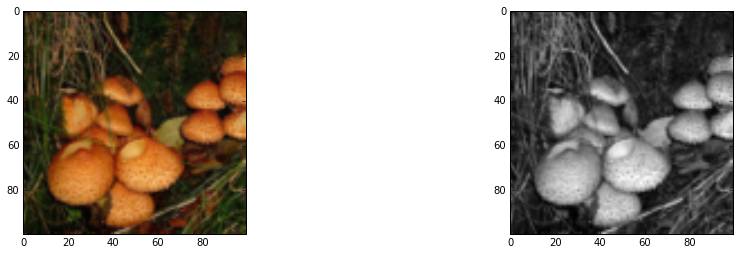

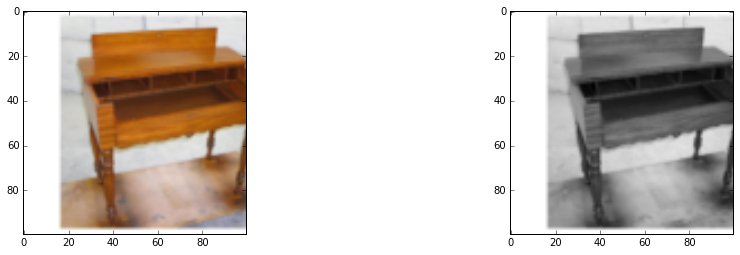

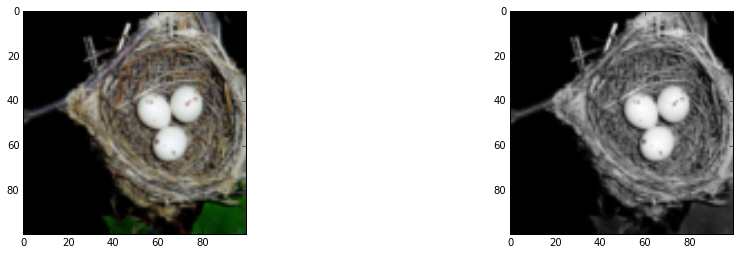

In [4]:
for c, g in downsampled[:3]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(c)
    ax2.imshow(g, cmap=cm.gray)

In [5]:
test = downsampled[:1000]
val = downsampled[1000:2000]
train = downsampled[2000:]

X_test = np.array([g for _, g in test])
y_test = np.array([c for c, _ in test])

X_val = np.array([g for _, g in val])
y_val = np.array([c for c, _ in val])

X_train = np.array([g for _, g in train])
y_train = np.array([c for c, _ in train])

# c.T.astype(np.float64) / (c.T.sum(axis=0) + 1)

In [6]:
class ProportionNormalizationLayer(lasagne.layers.Layer):

    def get_output_for(self, inp, **kwargs):
        return inp * inp.shape[1] / T.sum(inp, axis=1)

    
def ScaledSigmoid(beta):
    def Closure(x):
        return beta * T.nnet.sigmoid(x)
    return Closure


def BuildNet(input_var=None, height=HEIGHT, width=WIDTH):
    # Inputs are greyscale images.
    l_in = lasagne.layers.InputLayer(
        shape=(None, height, width),
        input_var=input_var)

    # Shuffle them into 1-channel images. 
    l_inshuf = lasagne.layers.DimshuffleLayer(
        l_in,
        (0, 'x', 1, 2))
    
    # Apply several convolutional layers, padding at each step to
    # maintain original image size. We first use a large number
    # of kernels and ReLUs for feature discovery.
    l_conv1 = lasagne.layers.Conv2DLayer(
        l_inshuf,
        num_filters=12,
        filter_size=(5, 5),
        pad="same",
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    l_conv2 = lasagne.layers.Conv2DLayer(
        l_conv1,
        num_filters=5,
        filter_size=(3, 3),
        pad="same",
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    
    # Last convolutional layer collapses back to 3 kernels, which
    # should represent luminosity scaling factors for R, G, and B
    # channels. We use a scaled sigmoid that produces outputs between
    # 0 and 3, which is what we observe as a typical range of
    # luminosity scaling factors.
    l_conv3 = lasagne.layers.Conv2DLayer(
        l_conv2,
        num_filters=3,
        filter_size=(3, 3),
        pad="same",
        nonlinearity=ScaledSigmoid(3),
        W=lasagne.init.GlorotUniform())
    
    # Flip the index of the channel so that outputs are in the proper
    # format for scipy color images.
    l_outshuf = lasagne.layers.DimshuffleLayer(
        l_conv3,
        (0, 2, 3, 1))
    #l_out = ProportionNormalizationLayer(l_conv3)
    return l_outshuf

In [7]:
def Minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    for i in range(0, len(inputs) - batch_size + 1, batch_size):
        yield (i, inputs[i:i + batch_size], targets[i:i + batch_size])


def CreateTheanoExprs(height=HEIGHT, width=WIDTH):
    # Inputs and outputs.
    input_var = T.tensor3("inputs")
    
    # Our target_var contains raw target images, but we're not actually
    # training on raw activation values. What we're trying to discover are
    # scaling factors that need to be applied to greyscale luminosities for
    # each channel to reconstruct the original image.
    target_var = T.tensor4("targets")
    target_ratios = target_var / (target_var.mean(axis=3, keepdims=True) + 1)
    
    # Build network.
    net = BuildNet(
        input_var=input_var,
        height=height,
        width=width)

    # Loss expression.
    # Since we don't have stochastic dropout, we can use the same loss
    # expr for training and validation. If we want to add a dropout layer,
    # then we need a separate loss expression for validation where stochastic
    # elements are explicitly frozen & dropout is disabled.
    prediction = lasagne.layers.get_output(net)
    loss = lasagne.objectives.squared_error(prediction, target_ratios).mean()

    # Weight updates during training.
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
        loss,
        params,
        learning_rate=0.001,
        momentum=0.9)

    # Theano function to train a mini-batch.
    train_fn = theano.function(
        [input_var, target_var],
        loss,
        updates=updates,
        name="Train")

    # Thano function to evaluate / validate on an input.
    # The difference between this and the training function is that the
    # test / validation function does not apply weight updates.
    val_fn = theano.function(
        [input_var, target_var],
        [prediction, loss],
        name="Evaluate")
    
    return net, train_fn, val_fn


def Test(batch_size, X_test, y_test, net, val_fn):
    mark = time.time()
    test_errs = []
    iterator = Minibatches(X_test, y_test, batch_size)
    for i, inputs, targets in iterator:
        print "Testing batch starting at {i}...".format(i=i)
        _, err = val_fn(inputs, targets)
        test_errs.append(err)
    test_err = np.mean(test_errs)
    test_time = time.time() - mark
    print ("\nTesting completed in {test_time:.2f} seconds. "
           "Test error = {t_err:.4f}.").format(
               test_time=test_time,
               t_err=test_err)
    return test_err


def Train(num_epochs, batch_size,
          X_train, y_train, X_val, y_val, X_test, y_test,
          net, train_fn, val_fn):
    # Record stats for each epoch
    epochs = []
    
    # Run through training data for each epoch
    for epoch in xrange(num_epochs):
        # Train
        mark = time.time()
        train_errs = []
        iterator = Minibatches(X_train, y_train, batch_size)
        for i, inputs, targets in iterator:
            print "Training batch starting at {i}...".format(i=i)
            train_errs.append(train_fn(inputs, targets))
        train_err = np.mean(train_errs)
        train_time = time.time() - mark
        
        # Validate
        mark = time.time()
        val_errs = []
        iterator = Minibatches(X_val, y_val, batch_size)
        for i, inputs, targets in iterator:
            print "Validating batch starting at {i}...".format(i=i)
            _, err = val_fn(inputs, targets)
            val_errs.append(err)
        val_err = np.mean(val_errs)
        val_time = time.time() - mark
        
        # Record & report metrics
        epochs.append((epoch, train_time, val_time, train_err, val_err))
        print ("\nFinished Epoch {epoch}:\n"
               "- training took {train_time:.2f} minutes\n"
               "- validation took {val_time:.2f} minutes\n"
               "- training error = {t_err:.4f}\n"
               "- validation error = {v_err:.4f}\n").format(
                   epoch=epoch,
                   train_time=train_time / 60,
                   val_time=val_time / 60,
                   t_err=train_err,
                   v_err=val_err)

    test_err = Test(batch_size, X_test, y_test, net, val_fn)
    return epochs, net, test_err
    

In [8]:
theano_exprs = CreateTheanoExprs()

In [9]:
epochs2, net, err = Train(
    100, 500,
    X_train, y_train, X_val, y_val, X_test, y_test,
    *theano_exprs)
epochs += epochs2

Training batch starting at 0...
Training batch starting at 500...
Training batch starting at 1000...
Training batch starting at 1500...
Training batch starting at 2000...
Training batch starting at 2500...
Training batch starting at 3000...
Training batch starting at 3500...
Training batch starting at 4000...
Training batch starting at 4500...
Training batch starting at 5000...
Training batch starting at 5500...
Training batch starting at 6000...
Training batch starting at 6500...
Training batch starting at 7000...
Training batch starting at 7500...
Training batch starting at 8000...
Training batch starting at 8500...
Training batch starting at 9000...
Training batch starting at 9500...
Training batch starting at 10000...
Training batch starting at 10500...
Training batch starting at 11000...
Training batch starting at 11500...
Training batch starting at 12000...
Training batch starting at 12500...
Training batch starting at 13000...
Training batch starting at 13500...
Training batch s

NameError: name 'epochs' is not defined

In [ ]:
import random

eval_fn = theano_exprs[2]
indices = range(len(X_test))
random.shuffle(indices)

for i in indices[:10]:
    color = y_test[i]
    grey = X_test[i]
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
    w, _ = eval_fn(
        grey.reshape(1, 100, 100),
        color.reshape(1, 100, 100, 3))
    w = w.reshape(100, 100, 3)
    restoration = np.stack(
        [grey * w[:, :, 0],
         grey * w[:, :, 1],
         grey * w[:, :, 2]],
        axis=2)
    ax0.imshow(w)
    ax1.imshow(grey, cmap=cm.gray)
    ax2.imshow(color)
    ax3.imshow(restoration)
    plt.show()

In [ ]:
for i in xrange(5):
    y = y_test[i]
    x = X_test[i].astype(np.float64)
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(y)
    for j, color in enumerate(["red", "green", "blue"]):
        scaled = y[:,:,j] / x
        ax1.hist(scaled.reshape(np.product(scaled.shape)), color=color, alpha=0.5,
                 histtype="stepfilled", bins=np.array(range(300)) / 100.)
    plt.show()